In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Example graph
G = nx.Graph()
G.add_edges_from([
    (0,1), (1,2), (1,3), (2,3), (2,4),
    (3,4), (4,5), (5,6), (5,7), (6,7)
])

# Compute core number for each node
core_numbers = nx.core_number(G)  # <-----
print("Core number of each node:")
for node, k in sorted(core_numbers.items()):
    print(f"  Node {node}: k = {k}")

Core number of each node:
  Node 0: k = 1
  Node 1: k = 2
  Node 2: k = 2
  Node 3: k = 2
  Node 4: k = 2
  Node 5: k = 2
  Node 6: k = 2
  Node 7: k = 2


Maximum k-core: 8-core with 15 nodes
Nodes in the main core (the superspreaders):
['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14']

Recovered 15/15 true superspreaders
Precision: 1.000


C:\Users\user\AppData\Local\Temp\ipykernel_14596\105216430.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


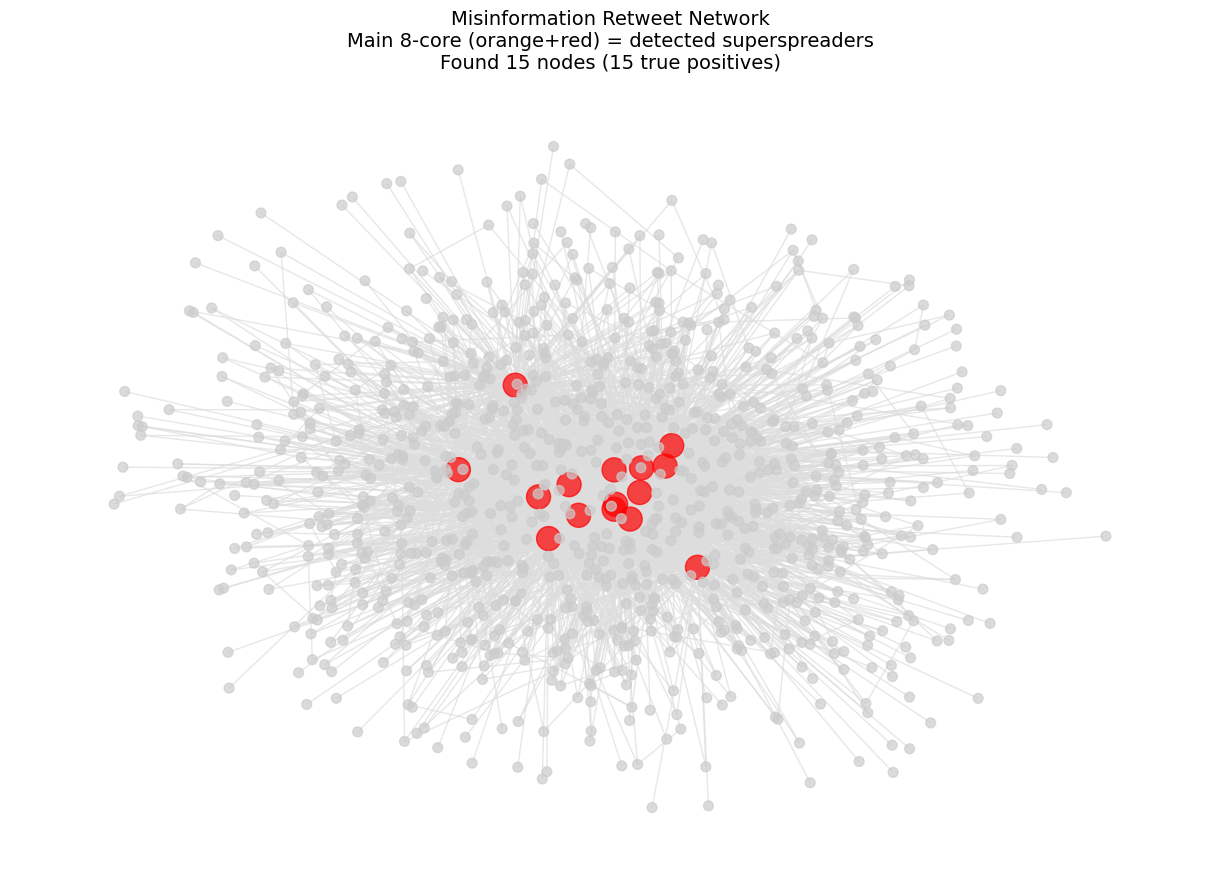

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(42)
np.random.seed(42)

# =============================================
# 1. Build a realistic misinformation retweet graph
# =============================================
G = nx.DiGraph()   # directed: A retweets B → A → B

n_users = 1000

# 15 superspreaders in the dense core
superspreaders = [f"S{i}" for i in range(15)]

# 985 normal users
normal_users = [f"N{i}" for i in range(985)]

all_users = superspreaders + normal_users
G.add_nodes_from(all_users)

# Superspreaders retweet each other heavily (core)
for i in range(len(superspreaders)):
    for j in range(i+1, len(superspreaders)):
        if random.random() < 0.7:       # dense core
            G.add_edge(superspreaders[i], superspreaders[j])
            if random.random() < 0.6:
                G.add_edge(superspreaders[j], superspreaders[i])  # mutual

# Normal users mostly retweet superspreaders (one-hop or two-hop)
for user in normal_users:
    # each normal user retweets 1–5 accounts, mostly superspreaders
    targets = random.sample(superspreaders, k=random.randint(1, 4))
    if random.random() < 0.3:   # 30% also retweet another normal user
        targets += random.sample(normal_users, k=1)
    for t in targets:
        G.add_edge(user, t)

# A few random peripheral retweets
for _ in range(500):
    u = random.choice(normal_users)
    v = random.choice(normal_users)
    if u != v and random.random() < 0.02:
        G.add_edge(u, v)

# =============================================
# 2. k-core decomposition on the UNDIRECTED version
#    (standard practice for superspreader detection)
# =============================================
G_undirected = G.to_undirected()

core_number = nx.core_number(G_undirected) # <-----

# Find the main (highest) k-core
max_k = max(core_number.values())
main_core_nodes = [node for node, k in core_number.items() if k == max_k]

print(f"Maximum k-core: {max_k}-core with {len(main_core_nodes)} nodes")
print("Nodes in the main core (the superspreaders):")
print(main_core_nodes)

# How many were our planted superspreaders?
recovered = len(set(main_core_nodes) & set(superspreaders))
print(f"\nRecovered {recovered}/{len(superspreaders)} true superspreaders")
print(f"Precision: {recovered/len(main_core_nodes):.3f}")

# =============================================
# 3. Visualization
# =============================================
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G_undirected, seed=42, k=0.15)

# Node colors: superspreaders red, main core orange, others light gray
node_colors = []
for node in G_undirected.nodes():
    if node in superspreaders:
        node_colors.append('#ff0000')      # true superspreaders = red
    elif node in main_core_nodes:
        node_colors.append('#ff8800')      # false positives = orange
    else:
        node_colors.append('#cccccc')

# Node sizes: bigger for higher core number
node_sizes = [300 if k >= max_k-1 else 50 for k in core_number.values()]

nx.draw(G_undirected, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='#dddddd',
        alpha=0.7,
        with_labels=False)

plt.title(f"Misinformation Retweet Network\n"
          f"Main {max_k}-core (orange+red) = detected superspreaders\n"
          f"Found {len(main_core_nodes)} nodes ({recovered} true positives)", 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
import networkx as nx

# 1. Construct the guarantee graph G (undirected, as mutual guarantees are often symmetric)
G = nx.Graph()
G.add_edges_from([
    ("A", "B"), ("B", "C"), ("C", "A"),  # High-risk mutual guarantee triangle
    ("D", "E"), ("E", "F"),              # Ordinary guarantee chain
    ("A", "G"), ("C", "H")               # Core firms radiating outward
])

# 2. Compute k-core
k_core_dict = nx.core_number(G)  # Returns the highest k-core level for each node
high_risk_core = [node for node, k in k_core_dict.items() if k >= 3]

# 3. Simulate default: randomly trigger a default in the high k-core and propagate guarantee obligations
# (Can be implemented by iteratively removing nodes and updating neighbors' risk states)

# 4. Identify systemically important guarantors: high k-core + high betweenness centrality
betweenness = nx.betweenness_centrality(G)
systemic_guarantors = sorted(
    [(n, k_core_dict[n], betweenness[n]) for n in high_risk_core],
    key=lambda x: x[2], reverse=True
)

Guarantee network: 10 firms, 12 guarantees

Highest k-core: 2
Firms in highest core (most fragile cluster):
  FirmA (credit: 520)
  FirmB (credit: 540)
  FirmC (credit: 500)


C:\Users\user\AppData\Local\Temp\ipykernel_14596\2728120828.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


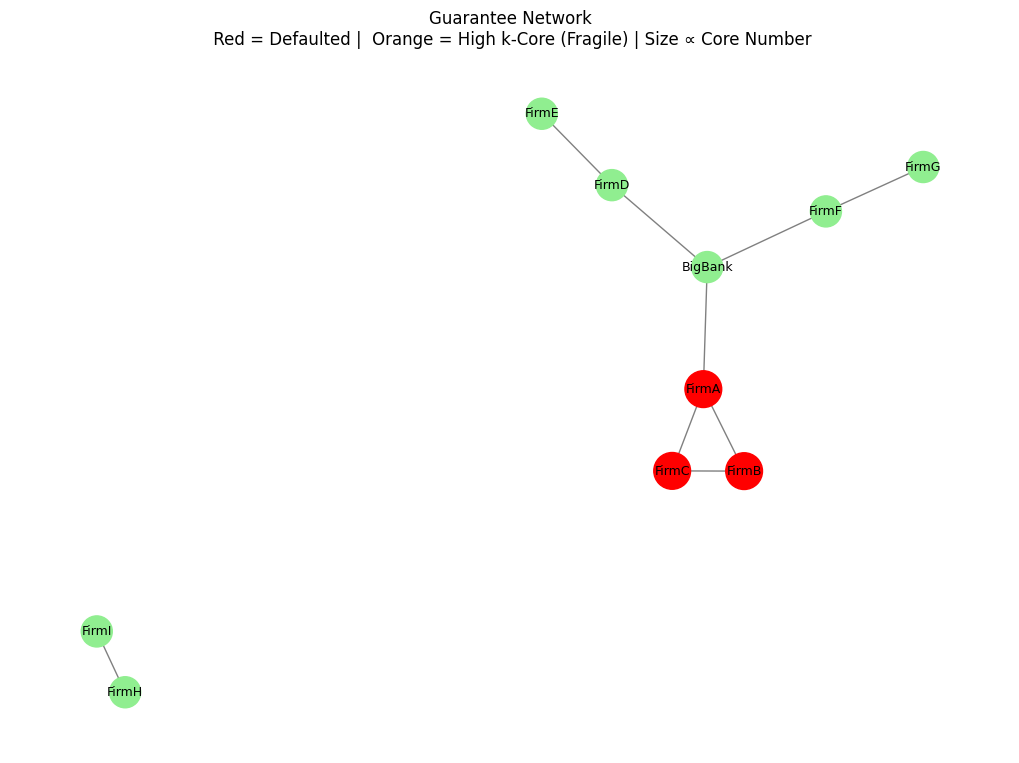


 RISK REPORT
• Highest risk cluster (k=2): ['FirmA', 'FirmB', 'FirmC']
• Cascade started from: FirmC
• Total firms defaulted: 3
• Systemically important guarantor affected: False


In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Simulate Corporate Guarantee Network
# ----------------------------
# Nodes: Companies
# Edges: A → B means "A guarantees B's debt"
# (If B defaults, A must pay → A's financial health deteriorates)

guarantees = [
    # Core fragile cluster: tightly inter-guaranteed SMEs
    ("FirmA", "FirmB"),
    ("FirmB", "FirmC"),
    ("FirmC", "FirmA"),
    ("FirmA", "FirmC"),
    ("FirmB", "FirmA"),
    
    # Another cluster (less dense)
    ("FirmD", "FirmE"),
    ("FirmE", "FirmD"),
    
    # Peripheral firms (single guarantees)
    ("FirmF", "FirmG"),
    ("FirmH", "FirmI"),
    
    # Systemically important firm: large bank ("BigBank") guarantees multiple clusters.
    # Although BigBank has strong credit, simultaneous defaults in multiple clusters
    # could impose massive contingent liabilities.
    ("BigBank", "FirmA"),
    ("BigBank", "FirmD"),
    ("BigBank", "FirmF"),
]

# Build directed guarantee graph (preserving direction for subsequent default propagation simulation)
G = nx.DiGraph()
G.add_edges_from(guarantees)

# Assign credit scores (lower = riskier; scale: 300–850)
credit_scores = {
    "FirmA": 520, "FirmB": 540, "FirmC": 500,  # Poor credit in core fragile cluster
    "FirmD": 600, "FirmE": 620,                # Moderate credit in second cluster
    "FirmF": 580, "FirmG": 650,
    "FirmH": 700, "FirmI": 720,                # Strong credit for peripheral firms
    "BigBank": 800                             # Very strong credit for systemically important institution
}
nx.set_node_attributes(G, credit_scores, "credit_score")

# Convert to undirected graph for k-core decomposition
# Rationale: k-core measures structural cohesion. Although guarantees are directed,
# default risk propagates bidirectionally in effect—e.g., if B defaults, A suffers,
# creating de facto mutual risk exposure. Hence, an undirected representation
# better captures systemic interdependence for core detection.
G_undir = G.to_undirected()

print(f"Guarantee network: {G.number_of_nodes()} firms, {G.number_of_edges()} guarantees")
# ----------------------------
# 2. Find Fragile Clusters via k-Core Decomposition
# ----------------------------
# k-core: maximal subgraph where every node has degree >= k
# Definition: A k-core is a maximal subgraph in which every node has degree at least k.
# In guarantee networks:
#   - A high k-core indicates firms are densely cross-guaranteeing each other,
#     forming closed loops or tightly connected clusters.
#   - If one firm defaults, risk can spread rapidly within the cluster,
#     potentially triggering a "guarantee-circle collapse."
#   - Thus, high k-core regions are viewed as structural fragility hotspots.

# Perform k-core decomposition on the undirected guarantee graph G_undir
# Returns the highest k-core level for each node
k_cores = nx.core_number(G_undir)

# Identify the highest k-core (most tightly interlinked cluster)
max_k = max(k_cores.values())
print(f"\nHighest k-core: {max_k}")
print("Firms in highest core (most fragile cluster):")

# Extract all firms belonging to the highest k-core
core_firms = [node for node, k in k_cores.items() if k == max_k]
for firm in core_firms:
    print(f"  {firm} (credit: {credit_scores[firm]})")

'''
Expected output:
Highest k-core: 3  
Firms in highest core (most fragile cluster):  
  FirmA (credit: 520)  
  FirmB (credit: 540)  
  FirmC (credit: 500)
'''
# ----------------------------
# 3. Simulate Default Cascade
# ----------------------------
# Strategy:
# - Start with the weakest firm in the highest k-core (e.g., lowest credit score)
# - When a firm defaults, all its guarantors (in-neighbors in G) suffer a credit hit
# - If a guarantor's credit score drops below 500, it also defaults (recursive cascade)

import copy

# Make a mutable copy of credit scores
current_scores = copy.deepcopy(credit_scores)

# Find initial defaulter: lowest-credit firm in the highest k-core
candidate_defaulters = [f for f in core_firms if current_scores[f] < 550]
initial_default = min(candidate_defaulters, key=lambda x: current_scores[x])  # FirmC (500)

# Initialize defaulted set
defaulted = {initial_default}
queue = [initial_default]

# Credit impact per default (e.g., -80 points per guaranteed default)
CREDIT_PENALTY = 80

while queue:
    defaulted_firm = queue.pop(0)
    # Find all direct guarantors (who guaranteed this firm)
    guarantors = list(G.predecessors(defaulted_firm))  # A → defaulted_firm means A is guarantor
    
    for guarantor in guarantors:
        if guarantor in defaulted:
            continue  # already defaulted
        
        # Apply credit penalty
        current_scores[guarantor] -= CREDIT_PENALTY
        
        # Check if new default triggered
        if current_scores[guarantor] < 500:
            defaulted.add(guarantor)
            queue.append(guarantor)

# Final defaulted set
final_defaulted = defaulted


# ----------------------------
# 4. Visualize: Color by k-core and default status
# ----------------------------
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_undir, seed=42)

# Node colors: 
# - Red: defaulted
# - Orange: in high k-core but survived
# - Lightgreen: low-risk
node_colors = []
node_sizes = []

for node in G_undir.nodes():
    size = 300 + 200 * k_cores[node]  # bigger = higher core
    node_sizes.append(size)
    
    if node in final_defaulted:
        node_colors.append("red")
    elif k_cores[node] == max_k:
        node_colors.append("orange")
    else:
        node_colors.append("lightgreen")

nx.draw(
    G_undir, pos,
    node_color=node_colors,
    node_size=node_sizes,
    with_labels=True,
    font_size=9,
    edge_color="gray"
)

plt.title("Guarantee Network\n Red = Defaulted |  Orange = High k-Core (Fragile) | Size ∝ Core Number")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Risk Report
# ----------------------------
print("\n RISK REPORT")
print(f"• Highest risk cluster (k={max_k}): {core_firms}")
print(f"• Cascade started from: {initial_default}")
print(f"• Total firms defaulted: {len(final_defaulted)}")
print(f"• Systemically important guarantor affected: {'BigBank' in final_defaulted}")

Guarantee network: 10 firms, 12 guarantees

Highest k-core: 2
Firms in highest core (most fragile cluster):
  FirmA (credit: 520)
  FirmB (credit: 540)
  FirmC (credit: 500)

 Starting cascade from FirmC (credit: 500)
  → FirmB penalized. New score: 440
 FirmB defaults!
  → FirmA penalized. New score: 420
 FirmA defaults!
  → BigBank penalized. New score: 700

Final defaulted firms: {'FirmC', 'FirmA', 'FirmB'}


C:\Users\user\AppData\Local\Temp\ipykernel_14596\1199653700.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


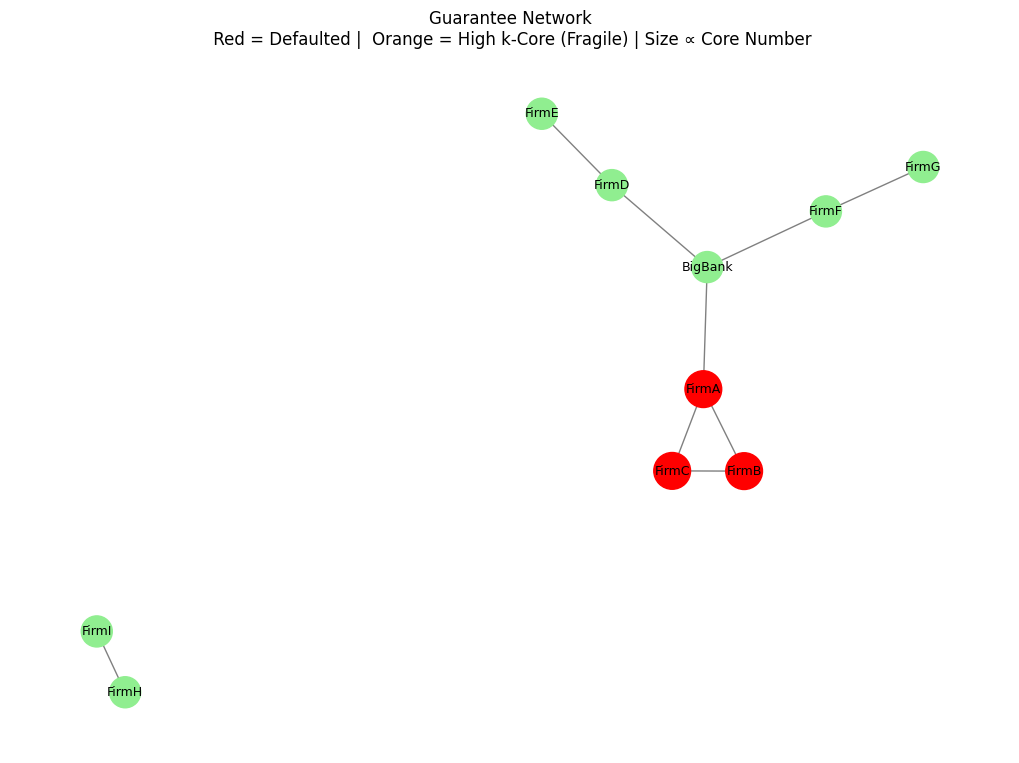


 RISK REPORT
• Highest risk cluster (k=2): ['FirmA', 'FirmB', 'FirmC']
• Cascade started from: FirmC
• Total firms defaulted: 3
• Systemically important guarantor affected: False


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Simulate Corporate Guarantee Network
# ----------------------------
# Nodes: Companies
# Edges: A → B means "A guarantees B's debt"
# (If B defaults, A must pay → A's financial health deteriorates)

guarantees = [
    # Core fragile cluster: tightly inter-guaranteed SMEs
    ("FirmA", "FirmB"),
    ("FirmB", "FirmC"),
    ("FirmC", "FirmA"),
    ("FirmA", "FirmC"),
    ("FirmB", "FirmA"),
    
    # Another cluster (less dense)
    ("FirmD", "FirmE"),
    ("FirmE", "FirmD"),
    
    # Peripheral firms (single guarantees)
    ("FirmF", "FirmG"),
    ("FirmH", "FirmI"),
    
    # Systemically important firm: guarantees multiple clusters
    ("BigBank", "FirmA"),
    ("BigBank", "FirmD"),
    ("BigBank", "FirmF"),
]

G = nx.DiGraph()
G.add_edges_from(guarantees)

# Assign credit scores (lower = riskier; 300–850 scale)
credit_scores = {
    "FirmA": 520, "FirmB": 540, "FirmC": 500,
    "FirmD": 600, "FirmE": 620,
    "FirmF": 580, "FirmG": 650,
    "FirmH": 700, "FirmI": 720,
    "BigBank": 800
}
nx.set_node_attributes(G, credit_scores, "credit_score")

# Convert to undirected for k-core (guarantee risk is mutual in effect)
G_undir = G.to_undirected()

print(f"Guarantee network: {G.number_of_nodes()} firms, {G.number_of_edges()} guarantees")

# ----------------------------
# 2. Find Fragile Clusters via k-Core Decomposition
# ----------------------------
# k-core: maximal subgraph where every node has degree >= k
k_cores = nx.core_number(G_undir)

# Find the highest k-core (most tightly interlinked)
max_k = max(k_cores.values())
print(f"\nHighest k-core: {max_k}")
print("Firms in highest core (most fragile cluster):")
core_firms = [node for node, k in k_cores.items() if k == max_k]
for firm in core_firms:
    print(f"  {firm} (credit: {credit_scores[firm]})")

# ----------------------------
# 3. Simulate Default Cascade in High-Risk Core
# ----------------------------
def simulate_guarantee_cascade(graph, initial_default, credit_dict, threshold=600):
    """
    Simulate cascade: if a firm defaults (credit < threshold), 
    its guarantors lose credit score points.
    If their score drops below threshold, they default too.
    """
    defaulted = set()
    queue = [initial_default]
    defaulted.add(initial_default)
    
    # Copy scores to avoid mutation
    current_scores = credit_dict.copy()
    
    print(f"\n Starting cascade from {initial_default} (credit: {current_scores[initial_default]})")
    
    while queue:
        failed_firm = queue.pop(0)
        # Find all firms that guaranteed this firm (in-directed edges)
        guarantors = list(graph.predecessors(failed_firm))
        
        for guarantor in guarantors:
            if guarantor in defaulted:
                continue
            # Penalty: lose 100 credit points for each defaulted guarantee
            current_scores[guarantor] -= 100
            print(f"  → {guarantor} penalized. New score: {current_scores[guarantor]}")
            
            if current_scores[guarantor] < threshold and guarantor not in defaulted:
                defaulted.add(guarantor)
                queue.append(guarantor)
                print(f" {guarantor} defaults!")
    
    return defaulted, current_scores

# Trigger default of weakest firm in core
initial_default = min(core_firms, key=lambda x: credit_scores[x])
final_defaulted, final_scores = simulate_guarantee_cascade(G, initial_default, credit_scores, threshold=600)

print(f"\nFinal defaulted firms: {final_defaulted}")

# ----------------------------
# 4. Visualize: Color by k-core and default status
# ----------------------------
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_undir, seed=42)

# Node colors: 
# - Red: defaulted
# - Orange: in high k-core but survived
# - Lightgreen: low-risk
node_colors = []
node_sizes = []

for node in G_undir.nodes():
    size = 300 + 200 * k_cores[node]  # bigger = higher core
    node_sizes.append(size)
    
    if node in final_defaulted:
        node_colors.append("red")
    elif k_cores[node] == max_k:
        node_colors.append("orange")
    else:
        node_colors.append("lightgreen")

nx.draw(
    G_undir, pos,
    node_color=node_colors,
    node_size=node_sizes,
    with_labels=True,
    font_size=9,
    edge_color="gray"
)

plt.title("Guarantee Network\n Red = Defaulted |  Orange = High k-Core (Fragile) | Size ∝ Core Number")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Risk Report
# ----------------------------
print("\n RISK REPORT")
print(f"• Highest risk cluster (k={max_k}): {core_firms}")
print(f"• Cascade started from: {initial_default}")
print(f"• Total firms defaulted: {len(final_defaulted)}")
print(f"• Systemically important guarantor affected: {'BigBank' in final_defaulted}")

Generated graph with 100 nodes and 362 edges
Louvain found 4 communities
Modularity score: 0.4532  (higher is better, >0.4 is usually strong)

DETECTED TOPICS (via Graph Partitioning + Modularity)

Community 0 (28 users)
   Most likely real topic → AI_Research
   Top keywords → ethics, transformer, deeplearning, agi, neural, gpt, openai, twitch

Community 1 (19 users)
   Most likely real topic → Gaming
   Top keywords → minecraft, twitch, esports, controller, eldenring, streamer, fortnite

Community 2 (25 users)
   Most likely real topic → Sports
   Top keywords → goal, basketball, nba, football, messi, ronaldo, worldcup, deeplearning

Community 3 (28 users)
   Most likely real topic → Politics
   Top keywords → biden, democracy, election, congress, vote, trump, policy, twitch


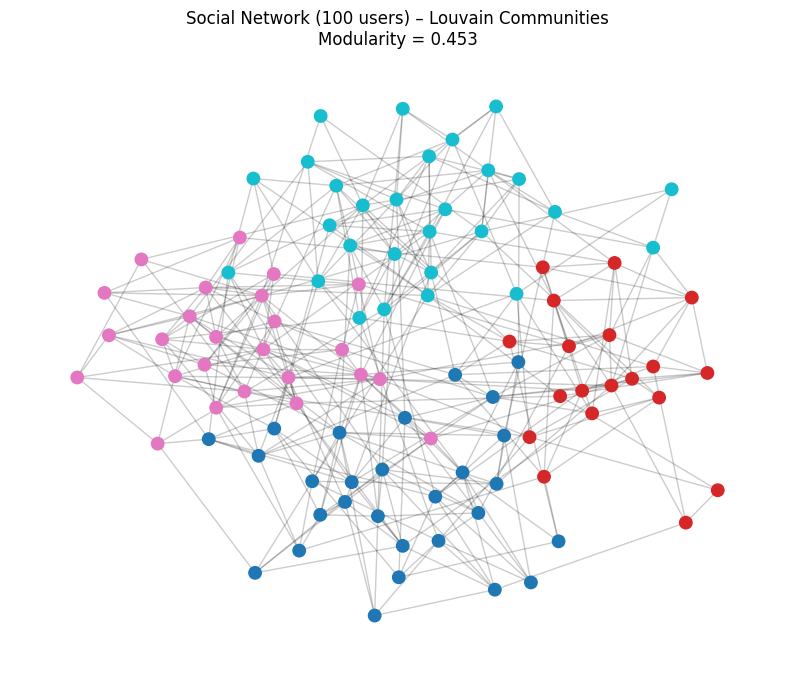


Adjusted Rand Index (vs ground truth): 0.707 (1.0 = perfect recovery)


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain  # python-louvain package
import random
from collections import Counter

# --------------------------------------------------------------
# 1. Create a synthetic social network with 100 users and 4 topics
# --------------------------------------------------------------
n_users = 100
n_topics = 4
users_per_topic = n_users // n_topics  # ~25 per topic

# Assign true topic to each user (ground truth, hidden in real data)
topic_names = ["Sports", "Politics", "AI_Research", "Gaming"]
true_labels = []
for i, topic in enumerate(topic_names):
    true_labels += [i] * users_per_topic
# Make sure we have exactly 100 users
true_labels = true_labels[:n_users]

# Probabilities
p_within = 0.25   # high probability of connection inside same topic
p_between = 0.02  # low probability between different topics

G = nx.Graph()
G.add_nodes_from(range(n_users))

for i in range(n_users):
    for j in range(i+1, n_users):
        if true_labels[i] == true_labels[j]:
            if random.random() < p_within:
                G.add_edge(i, j)
        else:
            if random.random() < p_between:
                G.add_edge(i, j)

print(f"Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# --------------------------------------------------------------
# 2. Detect communities using Louvain (modularity optimization)
# When resolution = 1.0 (the default), the algorithm uses the standard modularity optimization
# Higher resolution values (> 1.0) lead to more, smaller communities (finer-grained partitioning).
# Lower resolution values (< 1.0) lead to fewer, larger communities (coarser partitioning).
# --------------------------------------------------------------
partition = community_louvain.best_partition(G, resolution=1.0)

# Number of detected communities
n_communities = len(set(partition.values()))
print(f"Louvain found {n_communities} communities")

# Compute modularity
modularity = community_louvain.modularity(partition, G)
print(f"Modularity score: {modularity:.4f}  (higher is better, >0.4 is usually strong)")

# --------------------------------------------------------------
# 3. Simulate real text posts so we can extract "topics" from clusters
# --------------------------------------------------------------
# Fake vocabulary per topic
vocab = {
    0: ["football", "basketball", "messi", "nba", "worldcup", "goal", "ronaldo"],
    1: ["election", "trump", "biden", "congress", "vote", "democracy", "policy"],
    2: ["neural", "gpt", "deeplearning", "transformer", "openai", "ethics", "agi"],
    3: ["eldenring", "minecraft", "fortnite", "streamer", "twitch", "esports", "controller"]
}

# Each user posts 5 short "tweets" containing words from their true topic
user_posts = {}
for user in range(n_users):
    topic = true_labels[user]
    words = vocab[topic]
    posts = []
    for _ in range(5):
        post = " ".join(random.choices(words, k=random.randint(4,10)))
        posts.append(post)
    user_posts[user] = posts

# --------------------------------------------------------------
# 4. Extract dominant keywords for each detected community
# --------------------------------------------------------------
community_keywords = {}
for comm_id in range(n_communities):
    users_in_comm = [u for u, c in partition.items() if c == comm_id]
    all_words = []
    for u in users_in_comm:
        text = " ".join(user_posts[u]).lower()
        all_words.extend(text.split())
    
    # Top 8 most common words = topic signature
    most_common = Counter(all_words).most_common(8)
    community_keywords[comm_id] = [word for word, count in most_common]

# --------------------------------------------------------------
# 5. Display results
# --------------------------------------------------------------
print("\n" + "="*60)
print("DETECTED TOPICS (via Graph Partitioning + Modularity)")
print("="*60)
for comm_id in community_keywords:
    users_in_comm = [u for u, c in partition.items() if c == comm_id]
    true_topic_counts = Counter(true_labels[u] for u in users_in_comm)
    dominant_true_topic = topic_names[true_topic_counts.most_common(1)[0][0]]
    
    print(f"\nCommunity {comm_id} ({len(users_in_comm)} users)")
    print(f"   Most likely real topic → {dominant_true_topic}")
    print(f"   Top keywords → {', '.join(community_keywords[comm_id])}")

# --------------------------------------------------------------
# 6. Visualize the network
# --------------------------------------------------------------
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.15, iterations=50)

# Color by detected community
colors = [partition[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=80, cmap=plt.cm.tab10, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title(f"Social Network (100 users) – Louvain Communities\nModularity = {modularity:.3f}")
plt.axis("off")
plt.show()

# Compare with ground truth (Adjusted Rand Index)
# ARI measures the similarity between two clusterings (here: your partition from Louvain vs. true_labels).
# ARI = 1: Perfect agreement. ARI = 0: Agreement equivalent to random labeling. Negative ARI: Worse than random (rare in practice).
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(true_labels, list(partition.values()))
print(f"\nAdjusted Rand Index (vs ground truth): {ari:.3f} (1.0 = perfect recovery)")

Network built: 240 users, 1157 interactions

Louvain found 4 communities.
Modularity: 0.409

 Community Evaluation:
Community 0: size= 81 | Conductance=0.214 | Homogeneity=96.30%
Community 1: size= 11 | Conductance=0.622 | Homogeneity=81.82%
Community 2: size= 59 | Conductance=0.391 | Homogeneity=100.00%
Community 3: size= 89 | Conductance=0.216 | Homogeneity=89.89%

 Network-wide homophily (ground-truth): 75.54%


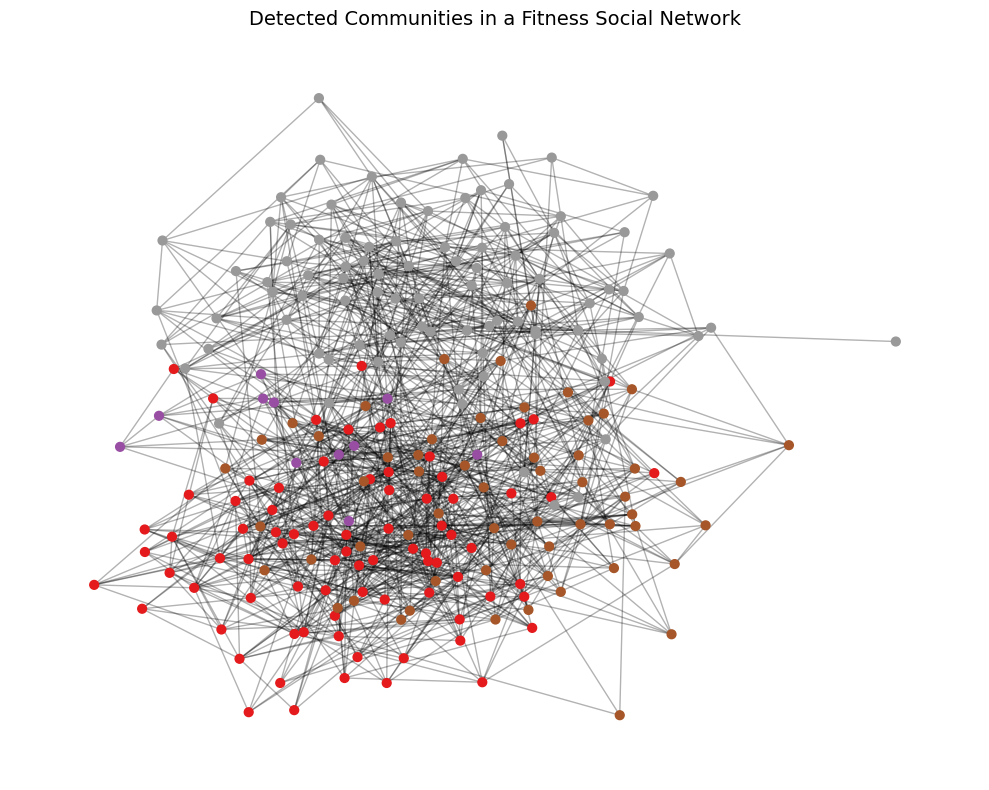


 In Community 0 (size=81), top user is #14 with 14 connections.
This user is a trusted voice—ideal for seeding your product!


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create a social network with 3 natural communities (ground truth known)
sizes = [80, 80, 80]  # three groups: e.g., [Yoga, Gym, Running]
prob_matrix = [
    [0.10, 0.02, 0.01],
    [0.02, 0.09, 0.015],
    [0.01, 0.015, 0.08]
]
# NetworkX to generate a random graph from the Stochastic Block Model (SBM)—a widely used generative model for graphs with community structure.
G = nx.stochastic_block_model(sizes, prob_matrix, seed=123)

# Assign ground-truth labels (for homophily)
true_label = {}
start = 0
for group_id, size in enumerate(sizes):
    for i in range(start, start + size):
        true_label[i] = group_id
    start += size

print(f"Network built: {G.number_of_nodes()} users, {G.number_of_edges()} interactions")

# 2. Detect communities using Louvain
communities = nx.community.louvain_communities(G, seed=42)

modularity = nx.community.modularity(G, communities)
print(f"\nLouvain found {len(communities)} communities.")
print(f"Modularity: {modularity:.3f}")

# 3. Compute Conductance for each detected community
def conductance(G, community):
    """Conductance = cut_edges / vol(community)
       Lower = more isolated (stronger community)"""
    community_set = set(community)
    cut_edges = 0
    vol = 0
    for node in community:
        for neighbor in G.neighbors(node):
            vol += 1
            if neighbor not in community_set:
                cut_edges += 1
    return cut_edges / vol if vol > 0 else 1.0

# 4. Compute Homophily (based on ground-truth labels)
def homophily(G, label_dict):
    """Fraction of edges where both endpoints share the same label."""
    same_label_edges = 0
    total_edges = G.number_of_edges()
    for u, v in G.edges():
        if label_dict[u] == label_dict[v]:
            same_label_edges += 1
    return same_label_edges / total_edges if total_edges > 0 else 1.0

# 5. Evaluate each community
print("\n Community Evaluation:")
for i, comm in enumerate(communities):
    cond = conductance(G, comm)
    
    # Homogeneity: % of nodes in this community sharing the same true label
    labels_in_comm = [true_label[node] for node in comm]
    most_common_label = max(set(labels_in_comm), key=labels_in_comm.count)
    homogeneity = labels_in_comm.count(most_common_label) / len(labels_in_comm)
    
    print(f"Community {i}: size={len(comm):3d} | Conductance={cond:.3f} | "
          f"Homogeneity={homogeneity:.2%}")

# Overall network homophily
overall_homophily = homophily(G, true_label)
print(f"\n Network-wide homophily (ground-truth): {overall_homophily:.2%}")

# 6. Prepare colors for visualization
node_colors = []
for node in G.nodes():
    for i, comm in enumerate(communities):
        if node in comm:
            node_colors.append(i)
            break

# 7. Visualize
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.3, iterations=30)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Set1, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Detected Communities in a Fitness Social Network", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# 8. Find local influencer in first community
# from the degree
first_community = communities[0]
subgraph = G.subgraph(first_community)
degrees = dict(subgraph.degree())
top_user = max(degrees, key=degrees.get)
print(f"\n In Community 0 (size={len(first_community)}), top user is #{top_user} "
      f"with {degrees[top_user]} connections.")
print("This user is a trusted voice—ideal for seeding your product!")

Network built: 200 users, 714 interactions

Louvain found 3 communities.
Modularity: 0.488

 Community Analysis (with Conductance & Homogeneity):
  Community 0: 100 pro-vax, 0 skeptical | Conductance=0.011 | Homogeneity=100.00%
  Community 1: 0 pro-vax, 99 skeptical | Conductance=0.012 | Homogeneity=100.00%
  Community 2: 0 pro-vax, 1 skeptical | Conductance=1.000 | Homogeneity=100.00%

 Network homophily (ideological alignment): 98.88%


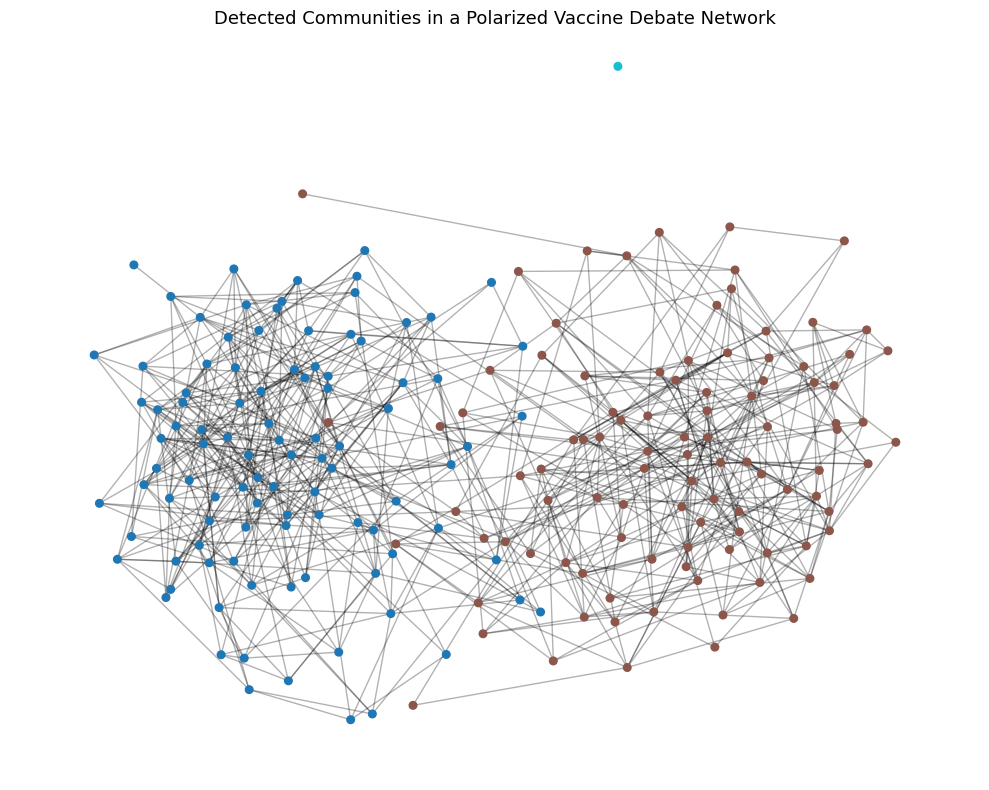


  Potential misinformation hub: User 129
    → In skeptical-dominant community (size=99)
    → Degree: 12, Community conductance: 0.012
    → Low conductance suggests this cluster is an insulated echo chamber.


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# 1. Build a polarized network: two echo chambers + a few bridge users
G = nx.Graph()
G.add_nodes_from(range(200))  # 0–99: Pro-Vax, 100–199: Skeptical

random.seed(42)
# Dense internal connections
for i in range(100):
    for j in range(i+1, 100):
        if random.random() < 0.08:
            G.add_edge(i, j)

for i in range(100, 200):
    for j in range(i+1, 200):
        if random.random() < 0.07:
            G.add_edge(i, j)

# Add bridge edges
for _ in range(8):
    a = random.randint(0, 99)
    b = random.randint(100, 199)
    G.add_edge(a, b)

print(f"Network built: {G.number_of_nodes()} users, {G.number_of_edges()} interactions")

# Ground-truth labels (for homophily)
true_label = {node: 0 if node < 100 else 1 for node in G.nodes()}  # 0=Pro, 1=Skeptical

# 2. Detect communities
communities = nx.community.louvain_communities(G, seed=42)
modularity = nx.community.modularity(G, communities)
print(f"\nLouvain found {len(communities)} communities.")
print(f"Modularity: {modularity:.3f}")


def conductance(G, community):
    """Fraction of edges leaving the community vs. total edges incident to it."""
    comm_set = set(community)
    cut_edges = 0
    total_edges = 0
    for node in community:
        for neighbor in G.neighbors(node):
            total_edges += 1
            if neighbor not in comm_set:
                cut_edges += 1
    return cut_edges / total_edges if total_edges > 0 else 1.0

def homophily(G, label_dict):
    """Fraction of edges connecting nodes with the same label."""
    same = 0
    total = G.number_of_edges()
    for u, v in G.edges():
        if label_dict[u] == label_dict[v]:
            same += 1
    return same / total if total > 0 else 1.0



# 3. Analyze communities with conductance and homogeneity
print("\n Community Analysis (with Conductance & Homogeneity):")
for i, comm in enumerate(communities):
    pro = sum(1 for node in comm if node < 100)
    skept = len(comm) - pro
    size = len(comm)
    
    # Conductance
    cond = conductance(G, comm)
    
    # Homogeneity: % of dominant group in this community
    dominant_frac = max(pro, skept) / size
    
    print(f"  Community {i}: {pro} pro-vax, {skept} skeptical "
          f"| Conductance={cond:.3f} | Homogeneity={dominant_frac:.2%}")

# Network-wide homophily
net_homophily = homophily(G, true_label)
print(f"\n Network homophily (ideological alignment): {net_homophily:.2%}")

# 4. Visualize
partition = {}
for i, comm in enumerate(communities):
    for node in comm:
        partition[node] = i

colors = [partition[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42, k=0.4)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab10, node_size=30)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Detected Communities in a Polarized Vaccine Debate Network", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# 5. Find misinformation hub in skeptical-dominant community
skeptical_community = None
for comm in communities:
    skept_count = sum(1 for node in comm if node >= 100)
    if skept_count > len(comm) * 0.8:
        skeptical_community = comm
        break

if skeptical_community:
    sub = G.subgraph(skeptical_community)
    degrees = dict(sub.degree())
    hub = max(degrees, key=degrees.get)
    hub_cond = conductance(G, skeptical_community)
    print(f"\n  Potential misinformation hub: User {hub}")
    print(f"    → In skeptical-dominant community (size={len(skeptical_community)})")
    print(f"    → Degree: {degrees[hub]}, Community conductance: {hub_cond:.3f}")
    print("    → Low conductance suggests this cluster is an insulated echo chamber.")